# GLM: Mini-batch ADVI on hierarchical regression model

Regression models have independent variables ($x$).
They affect the likelihood function, but are not random variables.
"When using mini-batch, we should take care of that."

In [1]:
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import theano
import theano.tensor as tt

%config InlineBackend.figure_format = 'retina'
gg.theme_set(gg.theme_minimal())

%load_ext memory_profiler

RANDOM_SEED = 606
np.random.seed(RANDOM_SEED)

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore


In [2]:
data = pd.read_csv(pm.get_data("radon.csv"))

county_names = data.county.unique()
county_idx = data["county_code"].values
n_counties = len(county_names)
total_size = data.shape[0]

For this example, `log_radon_t` is the dependent variable ($y$) and `floor_t` and `county_idx_t` are the independent variables ($x$).

In [3]:
log_radon_t = pm.Minibatch(data.log_radon.values, 100)
floor_t = pm.Minibatch(data.floor.values, 100)
county_idx_t = pm.Minibatch(data.county_code.values, 100)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/data.py:307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [4]:
theano.config.profile = True
theano.config.profile_memory = True

with pm.Model() as hierarchical_model_batch:
    # Hyperpriors
    μ_α = pm.Normal("μ_α", 0, 100 ** 2)
    σ_α = pm.Uniform("σ_α", lower=0, upper=100)
    μ_β = pm.Normal("μ_β", 0, 100 ** 2)
    σ_β = pm.Uniform("σ_β", 0, 100)

    # Prios
    α = pm.Normal("α", μ_α, σ_α, shape=n_counties)
    β = pm.Normal("β", μ_β, σ_β, shape=n_counties)

    # Main level
    radon_est = α[county_idx_t] + β[county_idx_t] * floor_t

    # Likelihood
    ϵ = pm.Uniform("ϵ", lower=0, upper=100)
    radon_like = pm.Normal(
        "radon_like", radon_est, ϵ, observed=log_radon_t, total_size=total_size
    )

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.


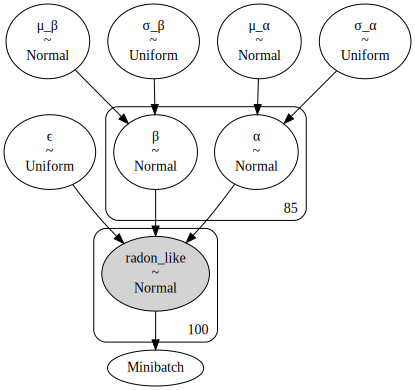

In [5]:
pm.model_to_graphviz(hierarchical_model_batch)

Run ADVI with mini-batch.

In [6]:
# with hierarchical_model_batch:
#     approx = pm.fit(
#         100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)]
#     )

In [7]:
# plot_data = pd.DataFrame({"x": np.arange(0, len(approx.hist)), "loss": approx.hist})

# (
#     gg.ggplot(plot_data, gg.aes(x="x", y="loss"))
#     + gg.geom_line(alpha=0.5, color="blue", size=1)
#     + gg.labs(x="sample", y="loss")
# )

In [8]:
with hierarchical_model_batch:
    hierarchical_batch_trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α, σ_β, μ_β, σ_α, μ_α]
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 112 seconds.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
hierarchical_model_batch.profile(hierarchical_model_batch.logpt).summary()

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
Function profiling
  Message: /usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/model.py:1191
  Time in 1000 calls to Function.__call__: 9.056106e-01s
  Time in Function.fn.__call__: 8.458211e-01s (93.398%)
  Time in thunks: 1.236014e-01s (13.648%)
  Total compile time: 6.830299e-01s
    Number of Apply nodes: 52
    Theano Optimizer time: 5.623939e-01s
       Theano validate time: 5.196095e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.581690e-02s
       Import time 9.930849e-03s
       Node make_thunk time 4.395700e-02s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}(TensorConstant{4.6051702}, ϵ, TensorConstant{0.0}, TensorConstant{100.0}, TensorConstant{-4.

In [10]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    μ_α = pm.Normal("μ_α", 0, 100 ** 2)
    σ_α = pm.Uniform("σ_α", lower=0, upper=100)
    μ_β = pm.Normal("μ_β", 0, 100 ** 2)
    σ_β = pm.Uniform("σ_β", 0, 100)

    # Prios
    α = pm.Normal("α", μ_α, σ_α, shape=n_counties)
    β = pm.Normal("β", μ_β, σ_β, shape=n_counties)

    # Main level
    radon_est = α[county_idx] + β[county_idx] * data.floor.values

    # Likelihood
    ϵ = pm.Uniform("ϵ", lower=0, upper=100)
    radon_like = pm.Normal("radon_like", radon_est, ϵ, observed=data.log_radon.values)

    hierarchical_trace = pm.sample(draws=2000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α, σ_β, μ_β, σ_α, μ_α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 70 seconds.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
hierarchical_model.profile(hierarchical_model.logpt).summary()

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/theano/gof/vm.py:886: UserWarning: CVM does not support memory profile, using Stack VM.
Function profiling
  Message: /usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/model.py:1191
  Time in 1000 calls to Function.__call__: 5.363848e-01s
  Time in Function.fn.__call__: 4.934466e-01s (91.995%)
  Time in thunks: 7.739759e-02s (14.429%)
  Total compile time: 4.092469e-01s
    Number of Apply nodes: 32
    Theano Optimizer time: 3.008530e-01s
       Theano validate time: 2.860308e-03s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.047896e-02s
       Import time 0.000000e+00s
       Node make_thunk time 1.917386e-02s
           Node Elemwise{Composite{((i0 + Switch(Cast{int8}((GE(i1, i2) * LE(i1, i3))), i4, i5)) - ((i6 * scalar_softplus((-i7))) + i7))}}(TensorConstant{4.6051702}, σ_β, TensorConstant{0.0}, TensorConstant{100.0}, TensorConstant{-